## Wstępna Analiza Danych - MOW 2
### 2016 UK Road Safety: Traffic Accidents and Vehicles

Anastazja Kandratsiuk, Bartosz Bojarski

Opis zbioru:
Zbiór danych zawiera informacje o wszystkich wypadkach drogowych w Wielkiej Brytani z roku 2016. Dane zostały przygotowane przez Departament Transportu Wielkiej Brytanii i przez inicjatywę Open Gov. Oryginalne dane są podzielone na cztery pliki, które opisują parametry dotyczące ofiar, pojazdów, czy okoliczności wypadków. Zostały one połączone w dwa zbiory danych, jeden opisujący geolokację wypadków, a drugi zawierający wszystkie pozostałe informacje.  
Część kolumn jest przygotowana w formie kodów, które wymagają przetłumaczenia na zrozumiałe wartości. Będzie to robione przy pomocy słowników, które zostały dostarczone wraz z danymi, a sama translacja będzie wykonywana w trakcie analizy danych.



Import bibliotek

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from shapely.geometry import Point


Wczytanie danych

In [84]:
Casualties = pd.read_csv('dane/Cas.csv')
MakeModel = pd.read_csv('dane/MakeModel2016.csv')
Accidents = pd.read_csv('dane/dftRoadSafety_Accidents_2016.csv', low_memory=False)
Vehicles = pd.read_csv('dane/Veh.csv')

Rozbicie danych na dane geograficzne i pozostałe

In [85]:
Comp_data = pd.merge(Accidents, Casualties, on='Accident_Index')
Comp_data = pd.merge(Comp_data, Vehicles, on='Accident_Index')
Comp_data = pd.merge(Comp_data, MakeModel, on='Accident_Index')

Geo_data = pd.DataFrame(Comp_data, columns=['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude'])
Data_no_geo = Comp_data.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude'], axis=1)

### Prezentacja podstawowych danych zbioru danych

Zbiór danych posiada 92 kolumny i 804853 wiersze. Kluczem głównym dla zbioru danych jest kolumna 'Accident_Index'. 
Kolejne cztery kolumny zawierają informacje o geolokalizacji wypadków. Pozostałe kolumny zawierają informacje o wypadkach, ofiarach, pojazdach, czy okolicznościach wypadków.

In [86]:
Comp_data.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Journey_Purpose_of_Driver_y,Sex_of_Driver_y,Age_Band_of_Driver_y,Engine_Capacity_(CC)_y,Propulsion_Code_y,Age_of_Vehicle_y,Driver_IMD_Decile_y,Driver_Home_Area_Type_y,make,model
0,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,1,1,8,-1,-1,-1,3,1,NaN,NaN
1,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,6,1,5,124,1,4,4,1,YAMAHA,HW 125 XENTER
2,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,1,1,8,-1,-1,-1,3,1,NaN,NaN
3,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,6,1,5,124,1,4,4,1,YAMAHA,HW 125 XENTER
4,2016010000006,551920.0,174560.0,0.184928,51.449595,1,3,1,1,01/11/2016,...,6,2,7,1461,2,1,10,1,MERCEDES,A180 BLUEEFFICIENCY SPORT CDI


In [87]:
Data_no_geo.describe()

,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,...,1st_Point_of_Impact_y,Was_Vehicle_Left_Hand_Drive,Journey_Purpose_of_Driver_y,Sex_of_Driver_y,Age_Band_of_Driver_y,Engine_Capacity_(CC)_y,Propulsion_Code_y,Age_of_Vehicle_y,Driver_IMD_Decile_y,Driver_Home_Area_Type_y
count,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804679.000000,...,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000
mean,30.762009,2.801886,2.722990,2.197789,4.102374,354.275910,3.825053,881.748876,5.028114,41.791845,...,1.745326,0.999745,4.751142,1.417705,6.122138,1537.945788,1.051839,5.871495,3.698314,0.932550
std,24.362049,0.445092,1.434966,2.020741,1.933958,249.474336,1.502124,1710.898103,1.663407,15.799111,...,1.095624,0.129218,1.978891,0.611939,2.903485,1625.727781,1.290594,5.855146,3.665153,1.086339
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,20.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,10.000000,3.000000,2.000000,1.000000,2.000000,139.000000,3.000000,0.000000,3.000000,30.000000,...,1.000000,1.000000,3.000000,1.000000,5.000000,998.000000,1.000000,1.000000,-1.000000,1.000000
50%,32.000000,3.000000,2.000000,2.000000,4.000000,346.000000,3.000000,62.000000,6.000000,30.000000,...,1.000000,1.000000,6.000000,1.000000,7.000000,1498.000000,1.000000,5.000000,4.000000,1.000000
75%,46.000000,3.000000,3.000000,3.000000,6.000000,530.000000,6.000000,614.000000,6.000000,60.000000,...,2.000000,1.000000,6.000000,2.000000,8.000000,1968.000000,2.000000,10.000000,7.000000,1.000000
max,98.000000,3.000000,16.000000,58.000000,7.000000,941.000000,6.000000,9918.000000,9.000000,70.000000,...,4.000000,2.000000,6.000000,3.000000,11.000000,91000.000000,12.000000,75.000000,10.000000,3.000000


### Sprawdzenie brakujących danych

W zbiorze danych znajdują się brakujące dane w niektórych kolumnach. By spełnić wymagania projektu, będziemy dodawać brakujące dane w kolumnach, które będą analizowane, by osiągnąć poziom około 10% brakujących danych. W chwili obecnej najwięcej brakujących danych mamy w przypadku informacji o modelu auta (około 15% brakujących danych), a następnie informacje o jednostce geograficznej w której doszło do wypadku (około 5% brakujących danych). Jednak ta metoda sprawdzania wartości brakujących jest niewystarczająca, ponieważ w zakodowanych kolumnach wartość -1 oznacza brakujące dane.

In [88]:
miss_data = Comp_data.isnull().sum()
miss_data = miss_data[miss_data >= 1]
print("Missing data that > 0:")
print(miss_data)

Missing data that > 0:
Location_Easting_OSGR            50
Location_Northing_OSGR           50
Longitude                        50
Latitude                         50
Time                             19
Speed_limit                     174
LSOA_of_Accident_Location     44515
make                         120749
model                        120749
dtype: int64


Przykładowa analiza dla prędkości limitów

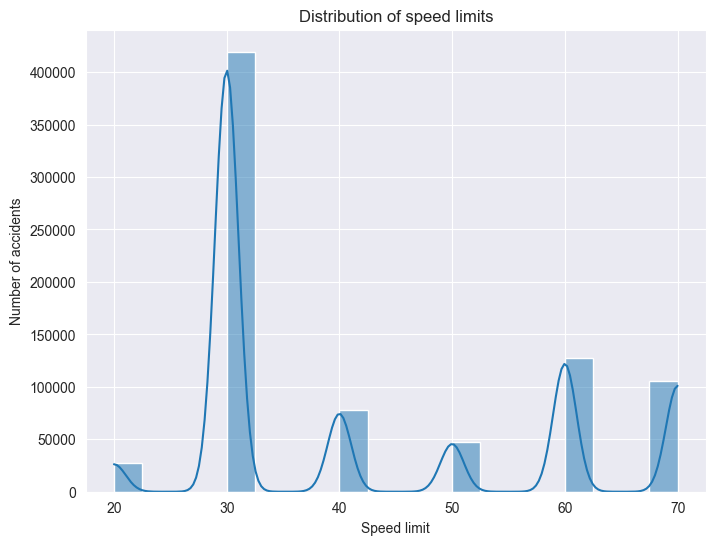

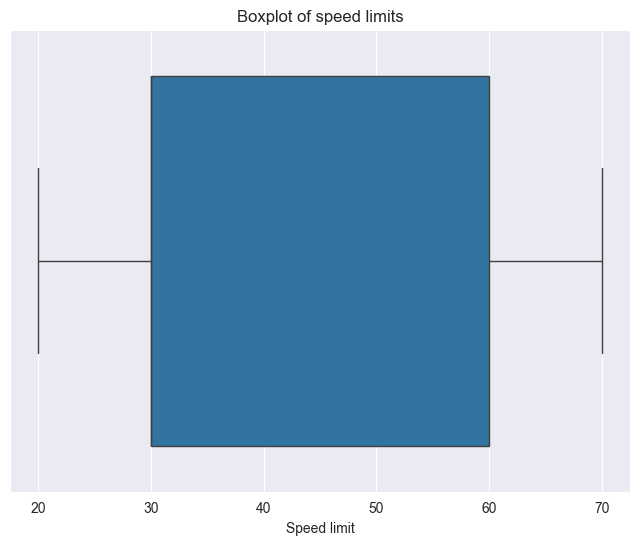

Descriptive statistics for speed limits:
count    804679.000000
mean         41.791845
std          15.799111
min          20.000000
25%          30.000000
50%          30.000000
75%          60.000000
max          70.000000
Name: Speed_limit, dtype: float64


In [89]:
# Histogram prędkości limitów
plt.figure(figsize=(8, 6))
sns.histplot(Comp_data['Speed_limit'], bins=20, kde=True)
plt.title('Distribution of speed limits')
plt.xlabel('Speed limit')
plt.ylabel('Number of accidents')
plt.show()

# Wykres pudełkowy prędkości limitów
plt.figure(figsize=(8, 6))
sns.boxplot(x=Comp_data['Speed_limit'])
plt.title('Boxplot of speed limits')
plt.xlabel('Speed limit')
plt.show()

# Statystyki opisowe prędkości limitów
print("Descriptive statistics for speed limits:")
print(Comp_data['Speed_limit'].describe())

Na podstawie danych dotyczących prędkości limitów można wywnioskować:
1. Średnia prędkość limitu wynosi około 41.79 mil na godzinę.
2. Odchylenie standardowe wynoszące około 15.80 sugeruje, że rozrzut prędkości limitów między wypadkami był stosunkowo niewielki w porównaniu do średniej wartości.
3. Wartości kwartyla 25% i 50% są identyczne i wynoszą 30 mil na godzinę, co oznacza, że większość wypadków miała miejsce na obszarach o niższej prędkości limitu.
4. Wartość maksymalna prędkości limitu wynosi 70 mil na godzinę. Występowanie przypadków wypadków na obszarach o wyższych prędkościach limitów może wskazywać na potencjalnie większe ryzyko dla bezpieczeństwa drogowego.

Analiza prędkości limitów według marki auta

In [90]:
missing_data_make = Comp_data.groupby('make')['Speed_limit'].apply(lambda x: x.isnull().sum())
missing_data_make = missing_data_make[missing_data_make != 0]
print(missing_data_make)

make
AUDI          14
BMW            7
CITROEN        9
FORD          22
IVECO          2
KIA            2
MAZDA          2
MERCEDES       6
MINI           2
MITSUBISHI     2
NISSAN         4
PEUGEOT        6
RENAULT        4
SUZUKI         2
TOYOTA         1
VAUXHALL      17
VOLKSWAGEN    13
Name: Speed_limit, dtype: int64


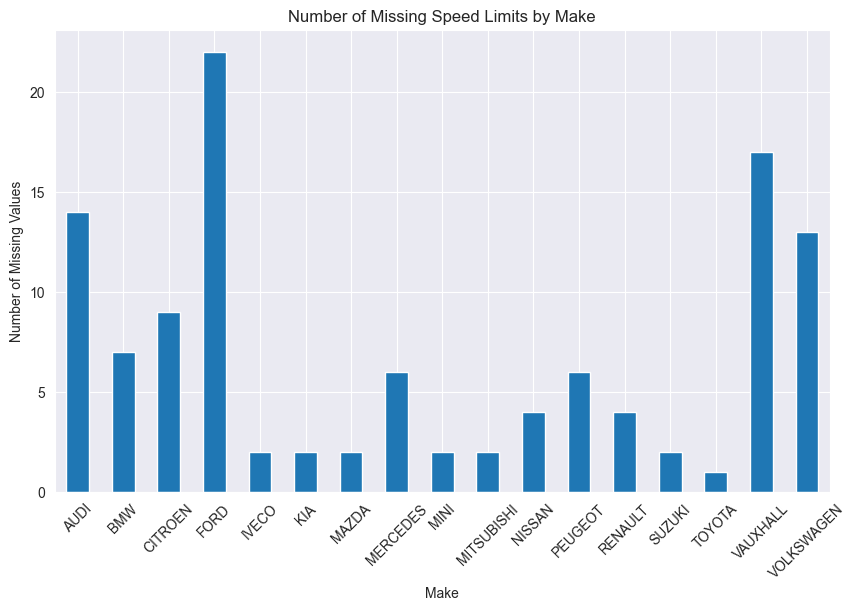

In [91]:
plt.figure(figsize=(10, 6))
missing_data_make.plot(kind='bar')
plt.title('Number of Missing Speed Limits by Make')
plt.xlabel('Make')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.show()

### Histogramy

Poniżej zaprezentowane są histogramy dla wybranych kolumn. Zaprezentowanie wszystkich histogramów w ramach jednego polecenia uniemożliwia wygodne odczytanie wartości z histogramów. Część z kolumn jest też zakodowana, więc nie ma sensu prezentować ich histogramów.

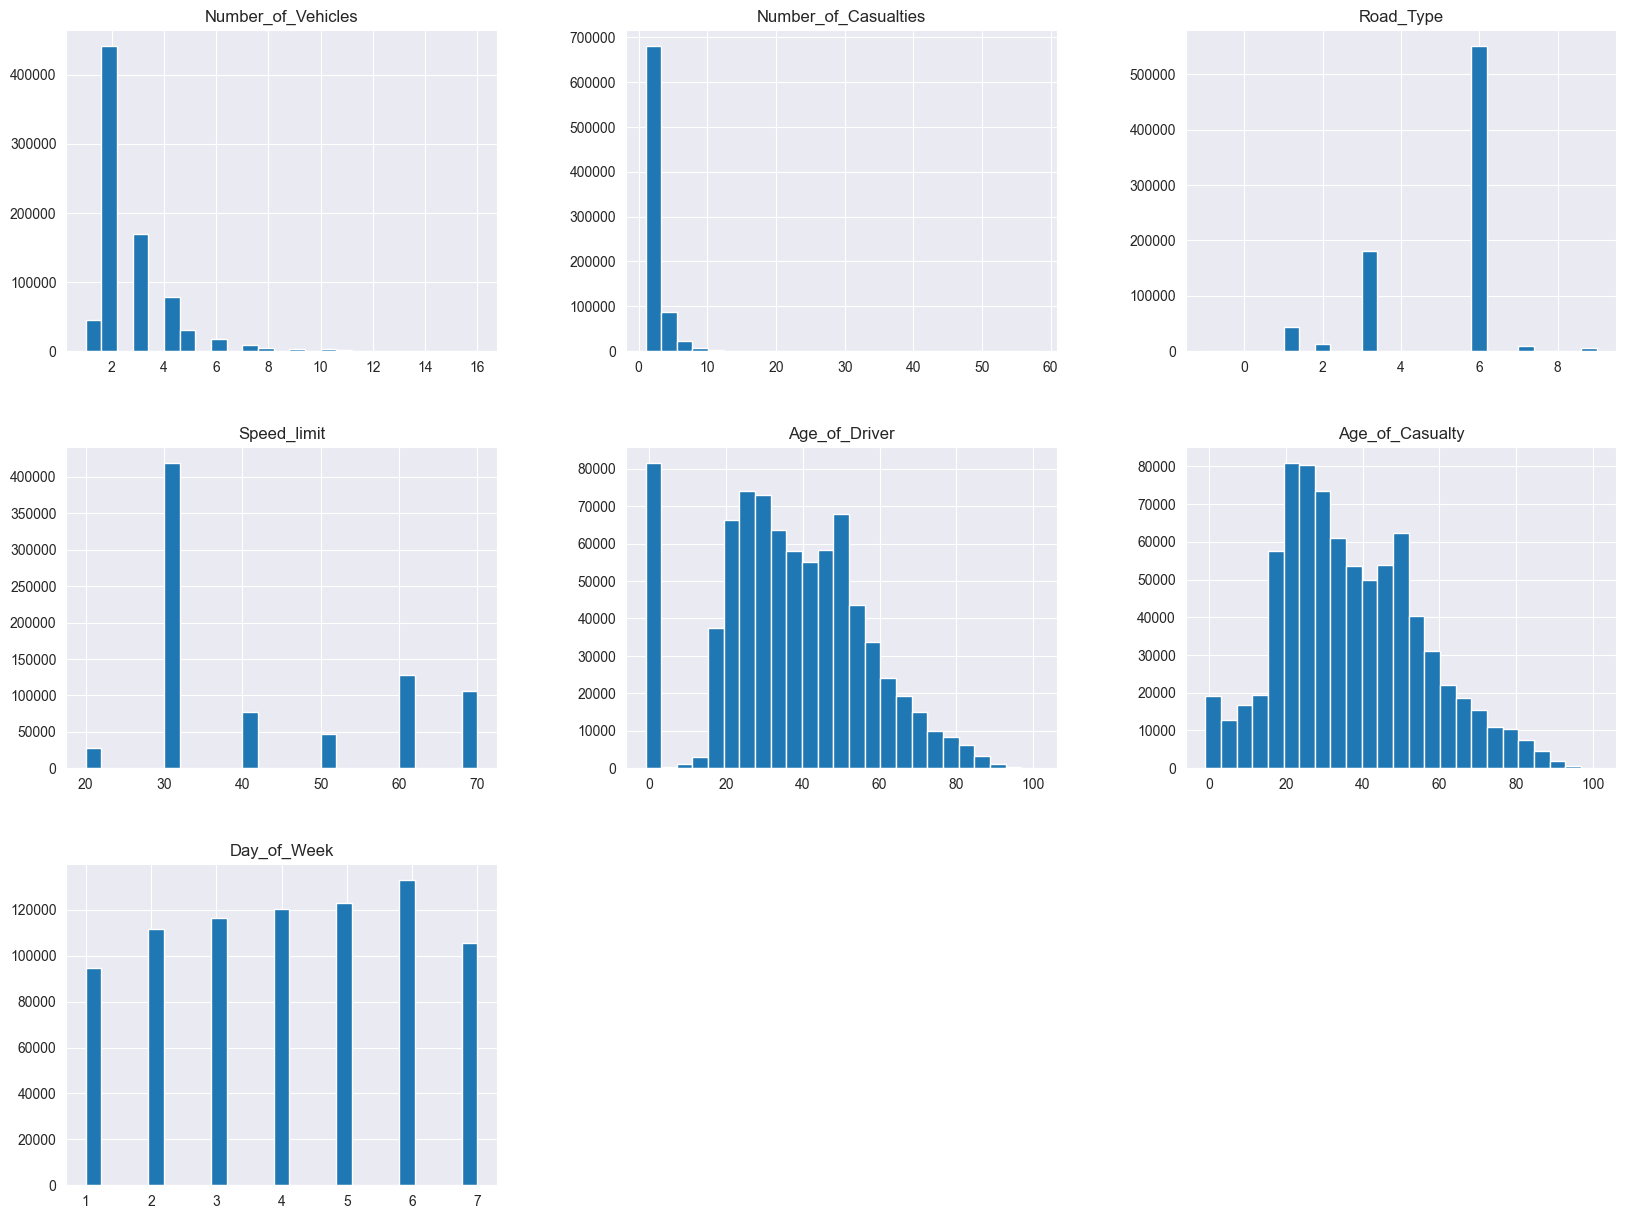

In [92]:
hist_subset = pd.DataFrame(Data_no_geo, columns=['Number_of_Vehicles', 'Number_of_Casualties', 'Road_Type', 'Speed_limit', 'Age_of_Driver', 'Age_of_Casualty', 'Day_of_Week'])
hist = hist_subset.hist(bins=25, figsize=(20,15))


Jak widać z powyższych wyreksów, większość wypadków drogowych w Wielkiej Brytanii odbywa się przy ograniczeniu prędkości do 30 mil na godzinę. Najwięcej wypadków drogowych ma miejsce w sobotę i piątek, a najmniej w poniedziałek. Największy odsetek kierowców powodujących wypadki to osoby w wieku 25-35 lat, choć dla ponad 10% wypadków wiek kierowcy nie jest znany. Analogicznie, najwięcej ofiar wypadków to osoby w wieku 25-35 lat. Można też wyczytać, że na większość wypadków drogowych przypada do 1 lub 2 pojazdy, a liczba ofiar wypadków zazwyczaj nie przekracza 5. Dodatkowo, najwięcej kolizji na drodze ma miejsce na drogach dwukierunkowych, jednopasmowych.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]),
 [Text(1, 0, 'Police_Force'),
  Text(2, 0, 'Accident_Severity'),
  Text(3, 0, 'Number_of_Vehicles'),
  Text(4, 0, 'Number_of_Casualties'),
  Text(5, 0, 'Day_of_Week'),
  Text(6, 0, 'Local_Authority_(District)'),
  Text(7, 0, '1st_Road_Class'),
  Text(8, 0, '1st_Road_Number'),
  Text(9, 0, 'Road_Type'),
  Text(10, 0, 'Speed_limit'),
  Text(11, 0, 'Junction_Detail'),
  Text(12, 0, 'Junction_Control'),
  Text(13, 0, '2nd_Road_Class'),
  Text(14, 0, '2nd_Road_Number'),
  Text(15, 0, 'Pedestrian_Crossing-Human_Control'),
  Text(16, 0, 'Pedestrian_Crossing-Physical_Facilities'),
  Text(17, 0, 'Light_Conditions'),
  Text(18, 0, 'Weat

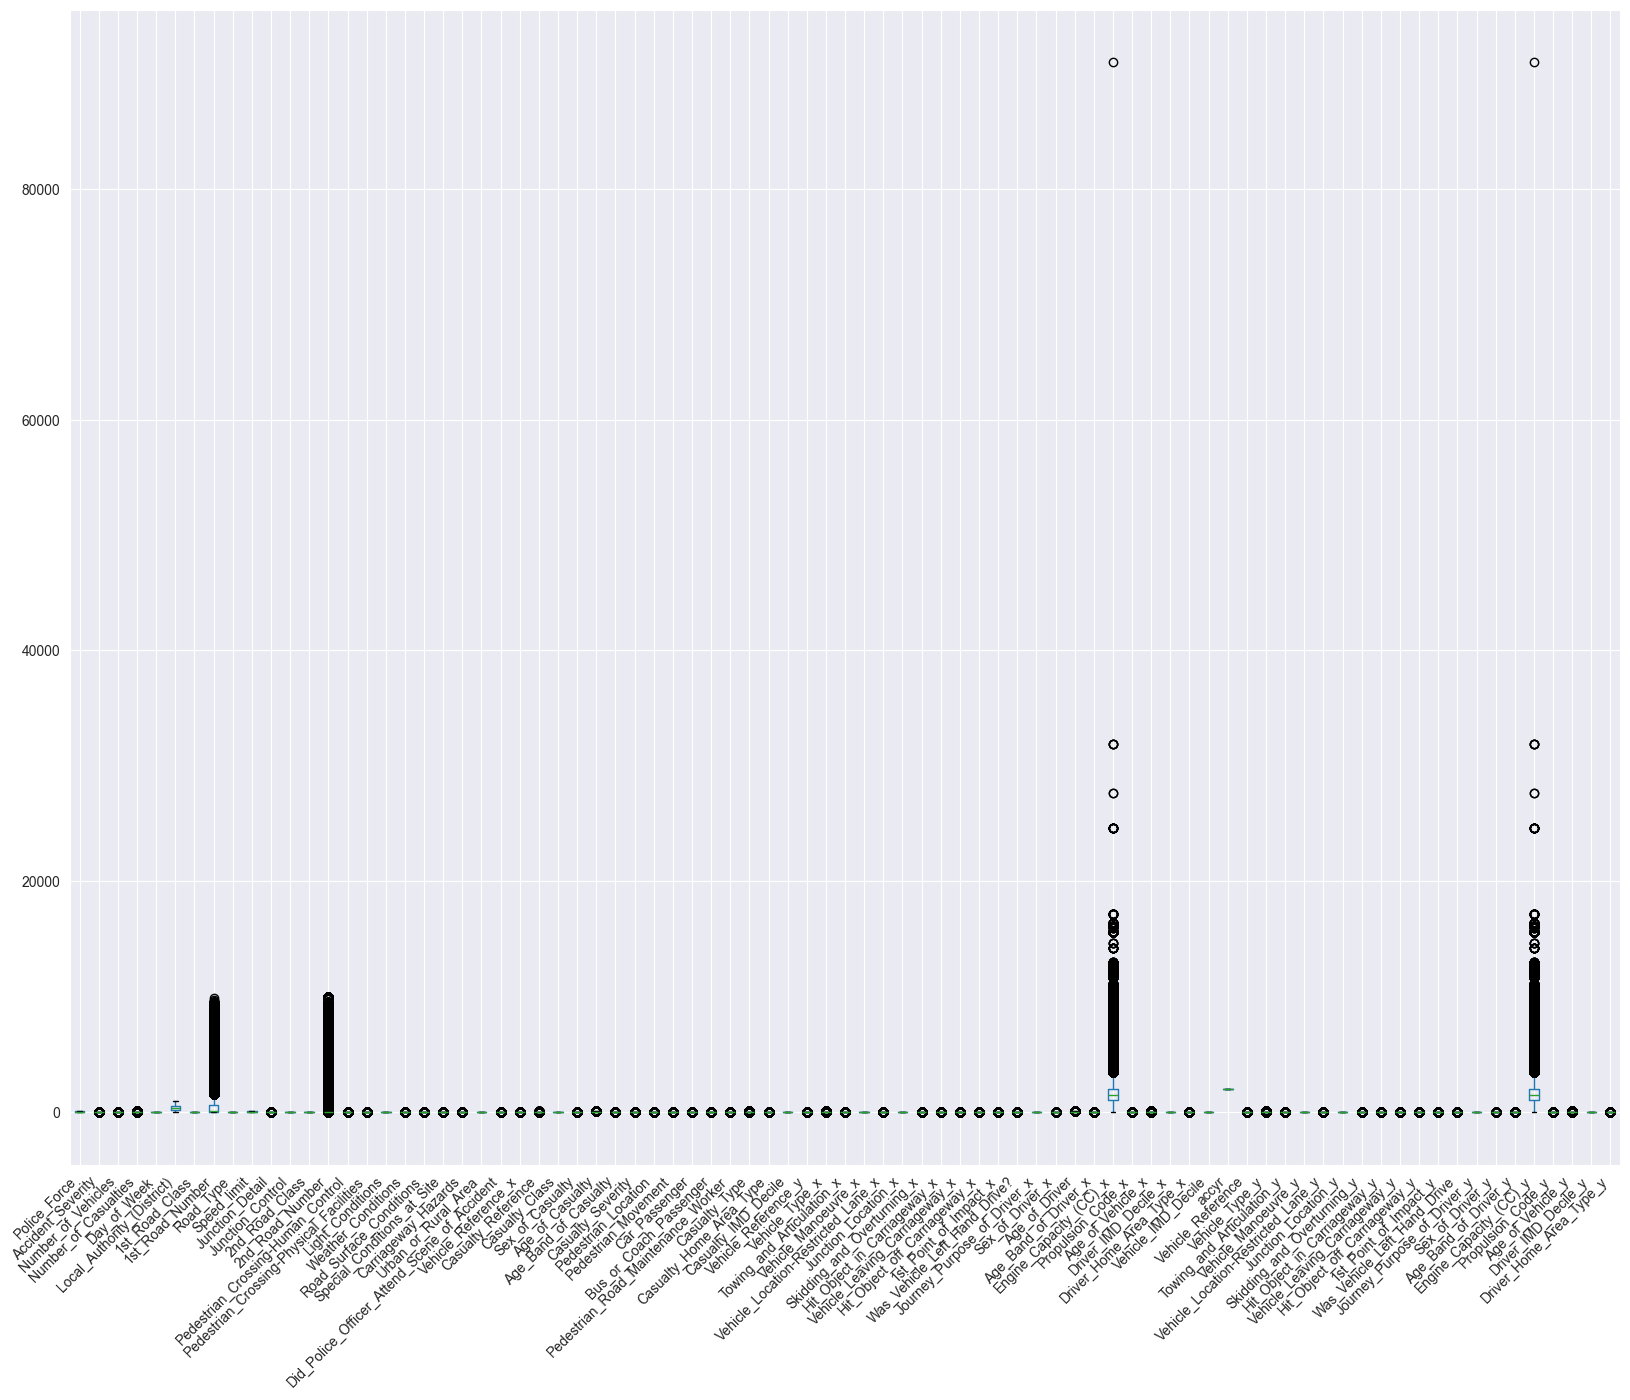

In [93]:
box = Data_no_geo.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)

### Wykresy typu Boxplot

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(1, 0, 'Vehicle_Reference'),
  Text(2, 0, 'Casualty_Reference'),
  Text(3, 0, 'Casualty_Class'),
  Text(4, 0, 'Sex_of_Casualty'),
  Text(5, 0, 'Age_of_Casualty'),
  Text(6, 0, 'Age_Band_of_Casualty'),
  Text(7, 0, 'Casualty_Severity'),
  Text(8, 0, 'Pedestrian_Location'),
  Text(9, 0, 'Pedestrian_Movement'),
  Text(10, 0, 'Car_Passenger'),
  Text(11, 0, 'Bus_or_Coach_Passenger'),
  Text(12, 0, 'Pedestrian_Road_Maintenance_Worker'),
  Text(13, 0, 'Casualty_Type'),
  Text(14, 0, 'Casualty_Home_Area_Type'),
  Text(15, 0, 'Casualty_IMD_Decile')])

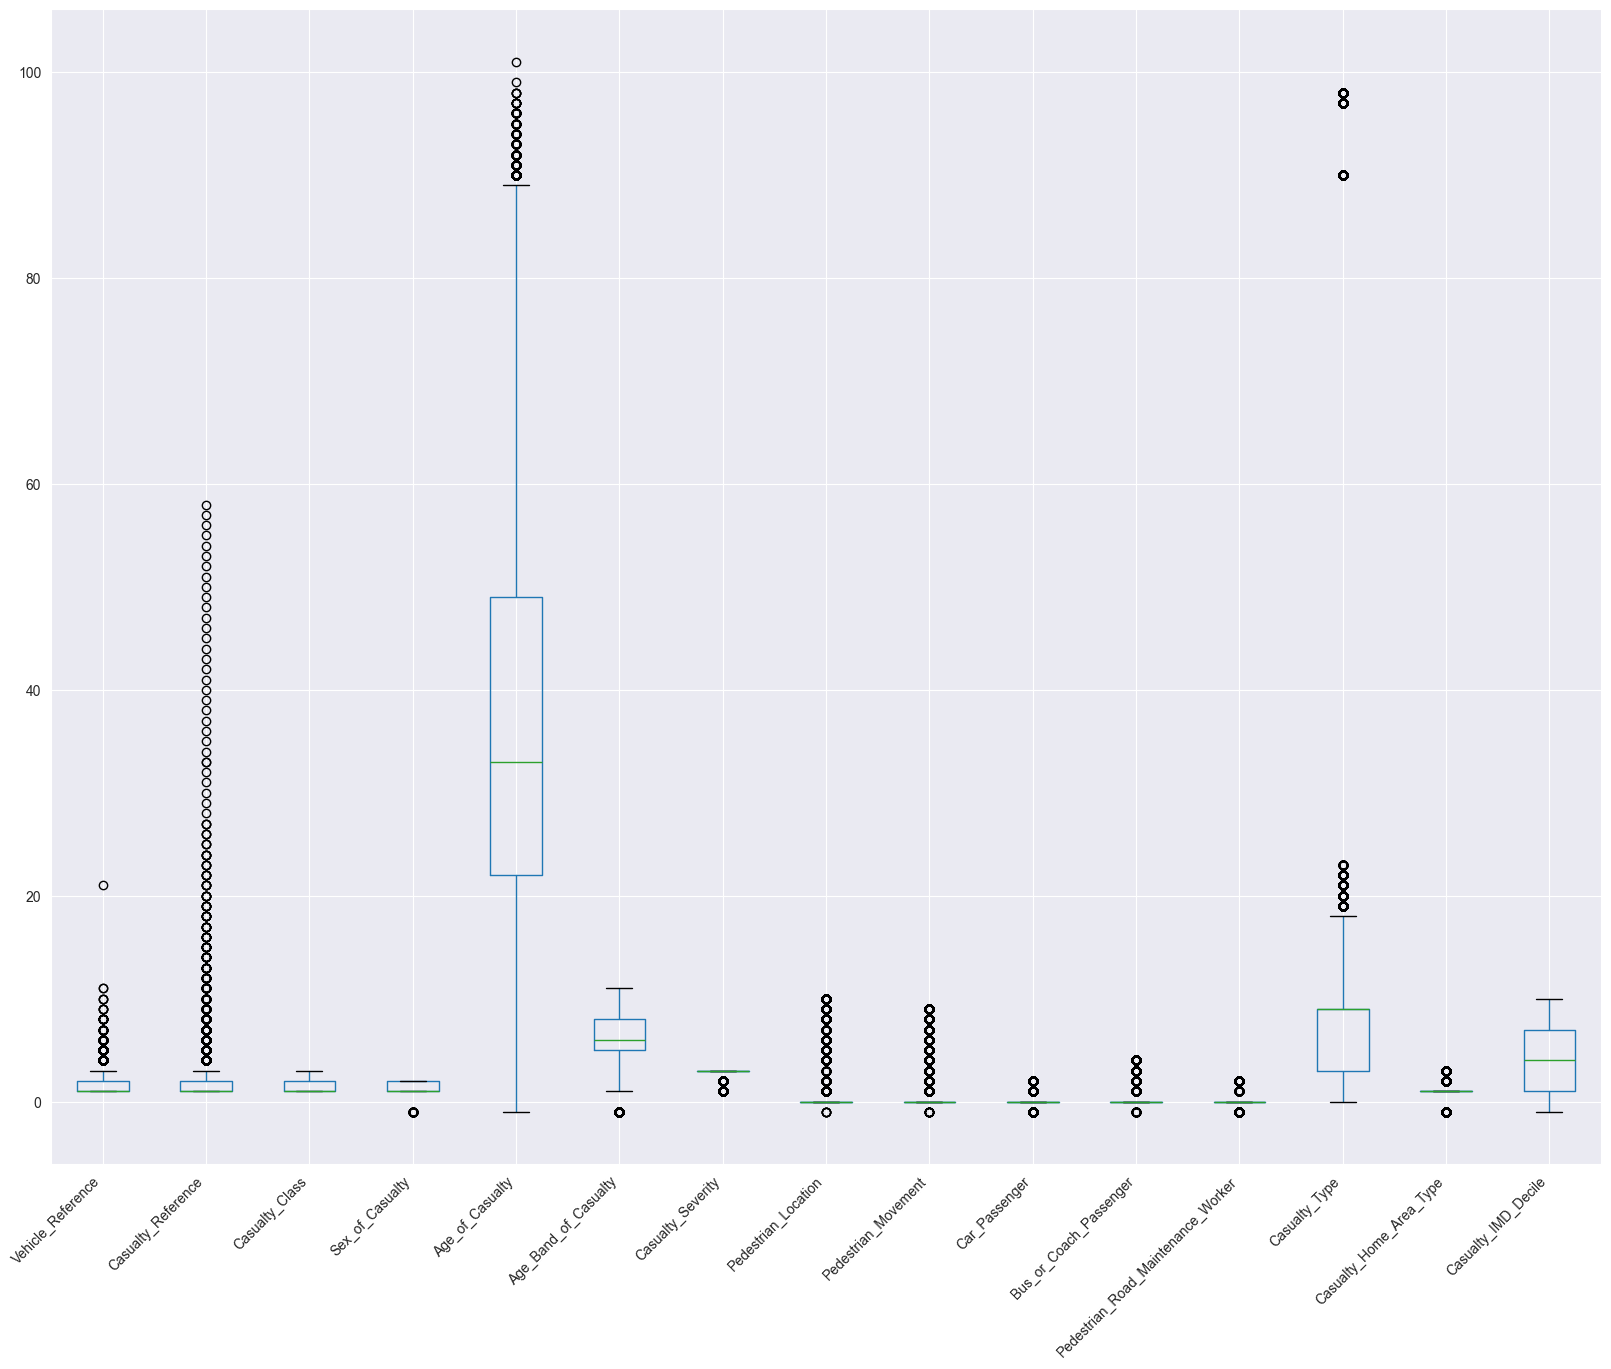

In [94]:
Casualties.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22]),
 [Text(1, 0, 'Vehicle_Reference'),
  Text(2, 0, 'Vehicle_Type'),
  Text(3, 0, 'Towing_and_Articulation'),
  Text(4, 0, 'Vehicle_Manoeuvre'),
  Text(5, 0, 'Vehicle_Location-Restricted_Lane'),
  Text(6, 0, 'Junction_Location'),
  Text(7, 0, 'Skidding_and_Overturning'),
  Text(8, 0, 'Hit_Object_in_Carriageway'),
  Text(9, 0, 'Vehicle_Leaving_Carriageway'),
  Text(10, 0, 'Hit_Object_off_Carriageway'),
  Text(11, 0, '1st_Point_of_Impact'),
  Text(12, 0, 'Was_Vehicle_Left_Hand_Drive?'),
  Text(13, 0, 'Journey_Purpose_of_Driver'),
  Text(14, 0, 'Sex_of_Driver'),
  Text(15, 0, 'Age_of_Driver'),
  Text(16, 0, 'Age_Band_of_Driver'),
  Text(17, 0, 'Engine_Capacity_(CC)'),
  Text(18, 0, 'Propulsion_Code'),
  Text(19, 0, 'Age_of_Vehicle'),
  Text(20, 0, 'Driver_IMD_Decile'),
  Text(21, 0, 'Driver_Home_Area_Type'),
  Text(22, 0, 'Vehicle_IMD_Decile')])

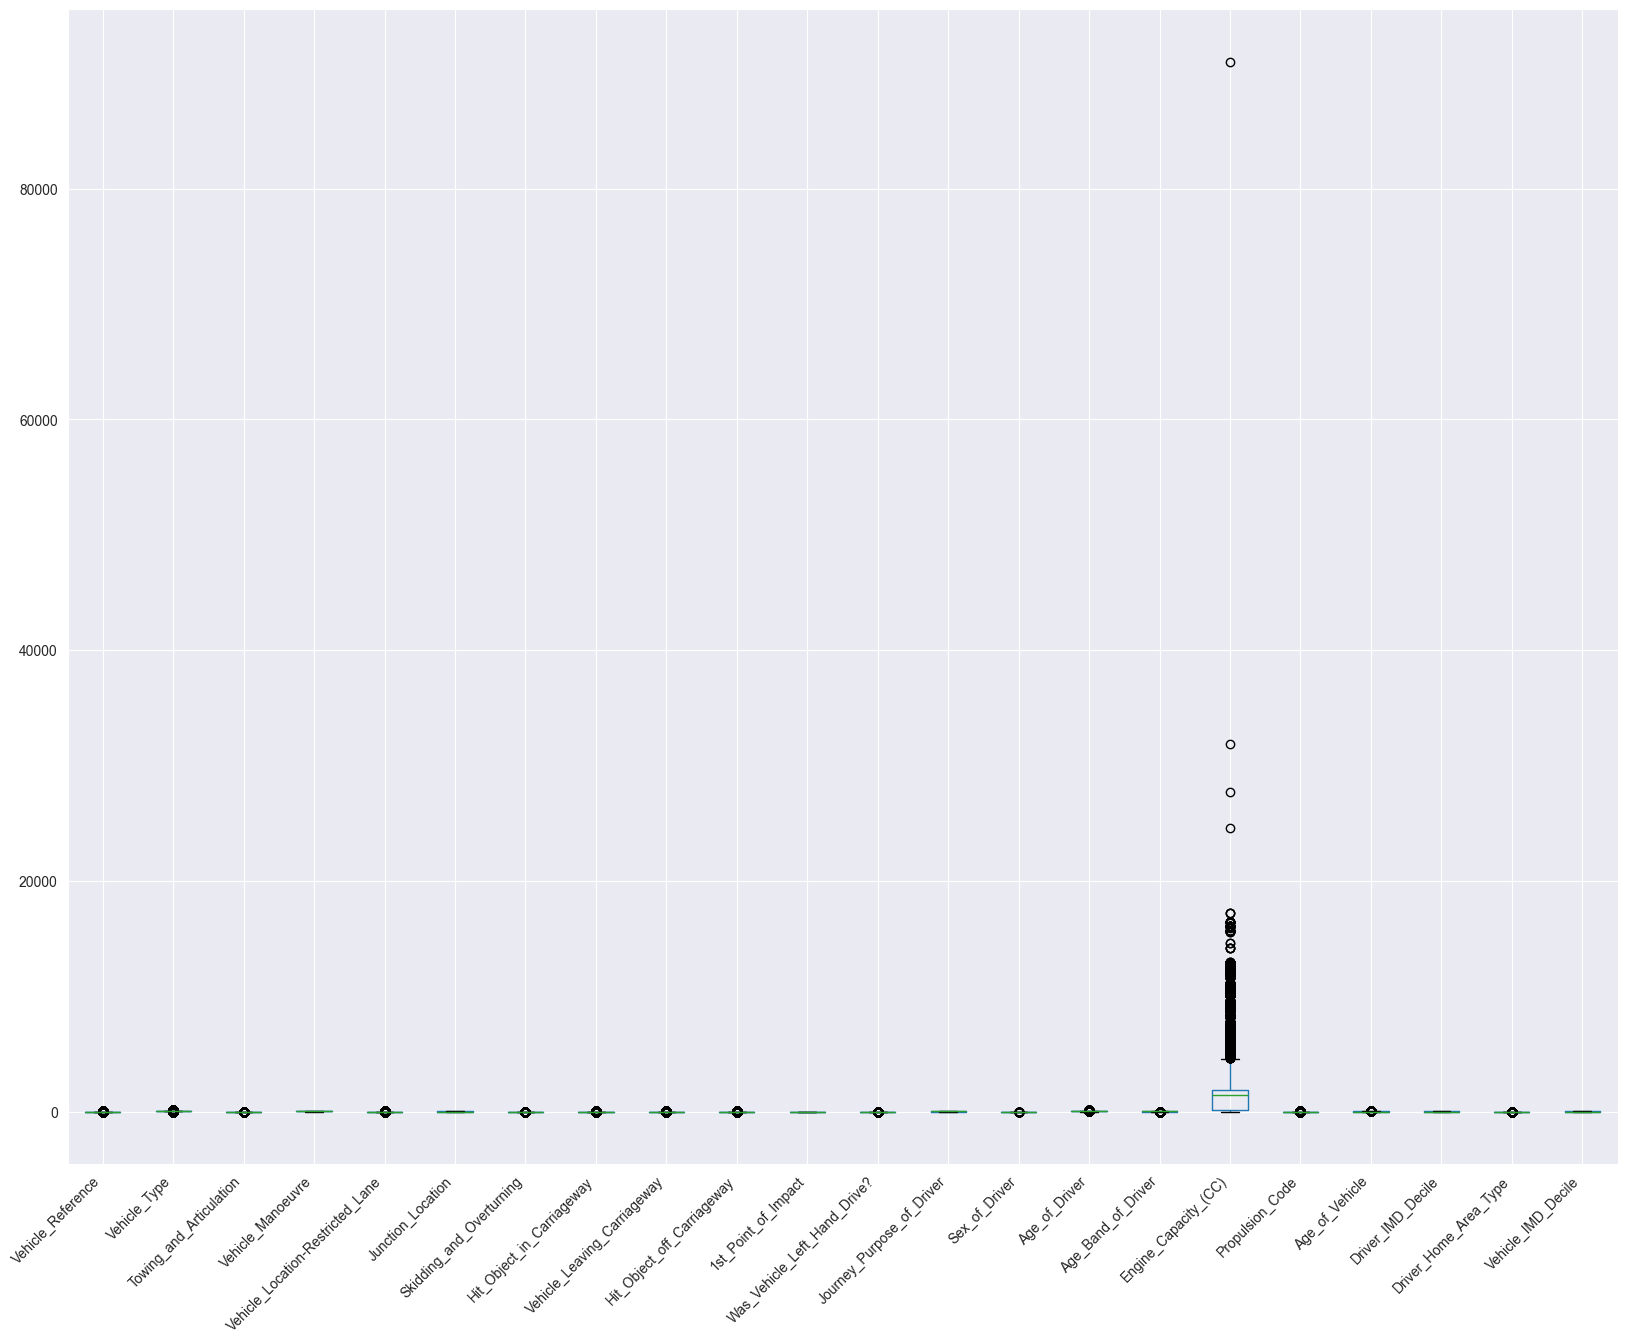

In [95]:
Vehicles.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21]),
 [Text(1, 0, 'accyr'),
  Text(2, 0, 'Vehicle_Reference'),
  Text(3, 0, 'Vehicle_Type'),
  Text(4, 0, 'Towing_and_Articulation'),
  Text(5, 0, 'Vehicle_Manoeuvre'),
  Text(6, 0, 'Vehicle_Location-Restricted_Lane'),
  Text(7, 0, 'Junction_Location'),
  Text(8, 0, 'Skidding_and_Overturning'),
  Text(9, 0, 'Hit_Object_in_Carriageway'),
  Text(10, 0, 'Vehicle_Leaving_Carriageway'),
  Text(11, 0, 'Hit_Object_off_Carriageway'),
  Text(12, 0, '1st_Point_of_Impact'),
  Text(13, 0, 'Was_Vehicle_Left_Hand_Drive'),
  Text(14, 0, 'Journey_Purpose_of_Driver'),
  Text(15, 0, 'Sex_of_Driver'),
  Text(16, 0, 'Age_Band_of_Driver'),
  Text(17, 0, 'Engine_Capacity_(CC)'),
  Text(18, 0, 'Propulsion_Code'),
  Text(19, 0, 'Age_of_Vehicle'),
  Text(20, 0, 'Driver_IMD_Decile'),
  Text(21, 0, 'Driver_Home_Area_Type')])

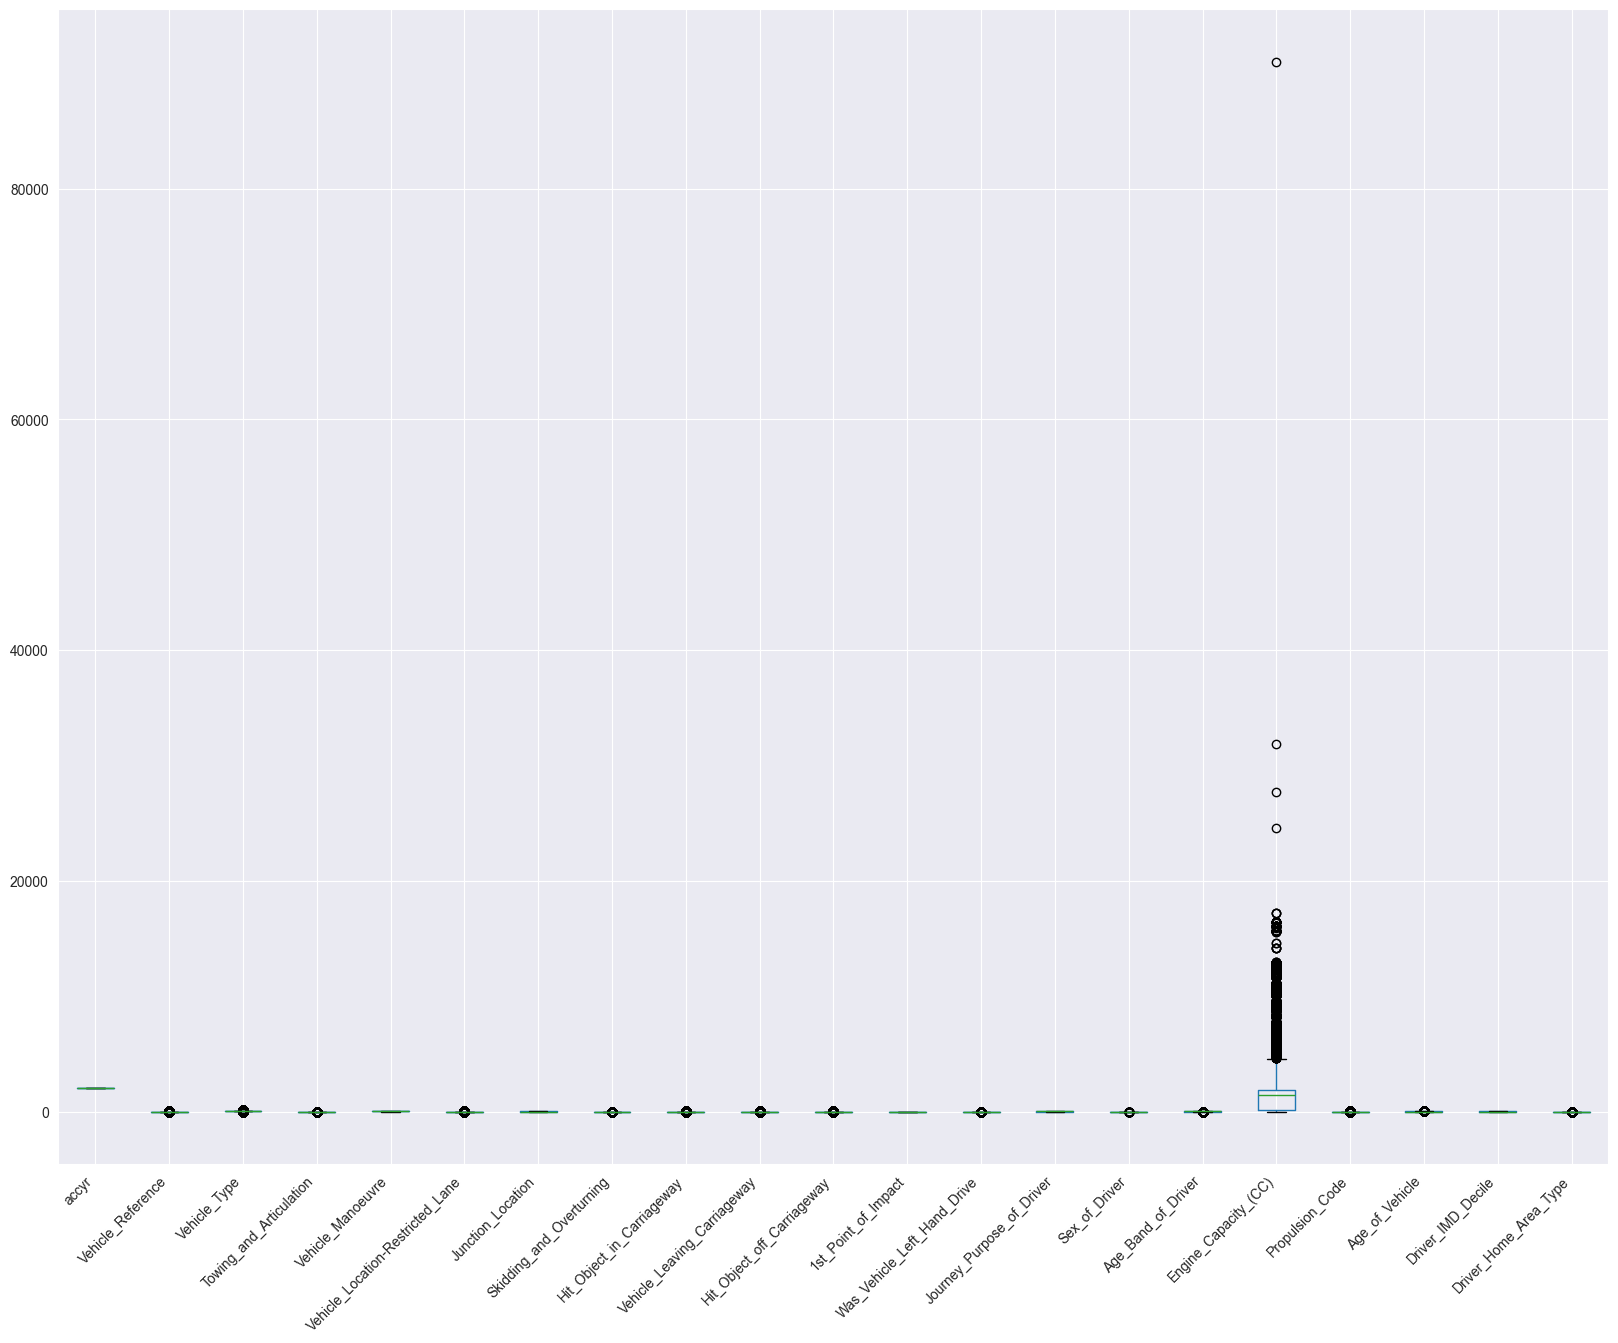

In [96]:
MakeModel.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(1, 0, 'Location_Easting_OSGR'),
  Text(2, 0, 'Location_Northing_OSGR'),
  Text(3, 0, 'Longitude'),
  Text(4, 0, 'Latitude'),
  Text(5, 0, 'Police_Force'),
  Text(6, 0, 'Accident_Severity'),
  Text(7, 0, 'Number_of_Vehicles'),
  Text(8, 0, 'Number_of_Casualties'),
  Text(9, 0, 'Day_of_Week'),
  Text(10, 0, 'Local_Authority_(District)'),
  Text(11, 0, '1st_Road_Class'),
  Text(12, 0, '1st_Road_Number'),
  Text(13, 0, 'Road_Type'),
  Text(14, 0, 'Speed_limit'),
  Text(15, 0, 'Junction_Detail'),
  Text(16, 0, 'Junction_Control'),
  Text(17, 0, '2nd_Road_Class'),
  Text(18, 0, '2nd_Road_Number'),
  Text(19, 0, 'Pedestrian_Crossing-Human_Control'),
  Text(20, 0, 'Pedestrian_Crossing-Physical_Facilities'),
  Text(21, 0, 'Light_Conditions'),
  Text(22, 0, 'Weather_Conditions'),
  Text(23, 0, 'Road_Surface_Conditions'),
  Text(24, 0, 'Special_Conditions_at_Site'),

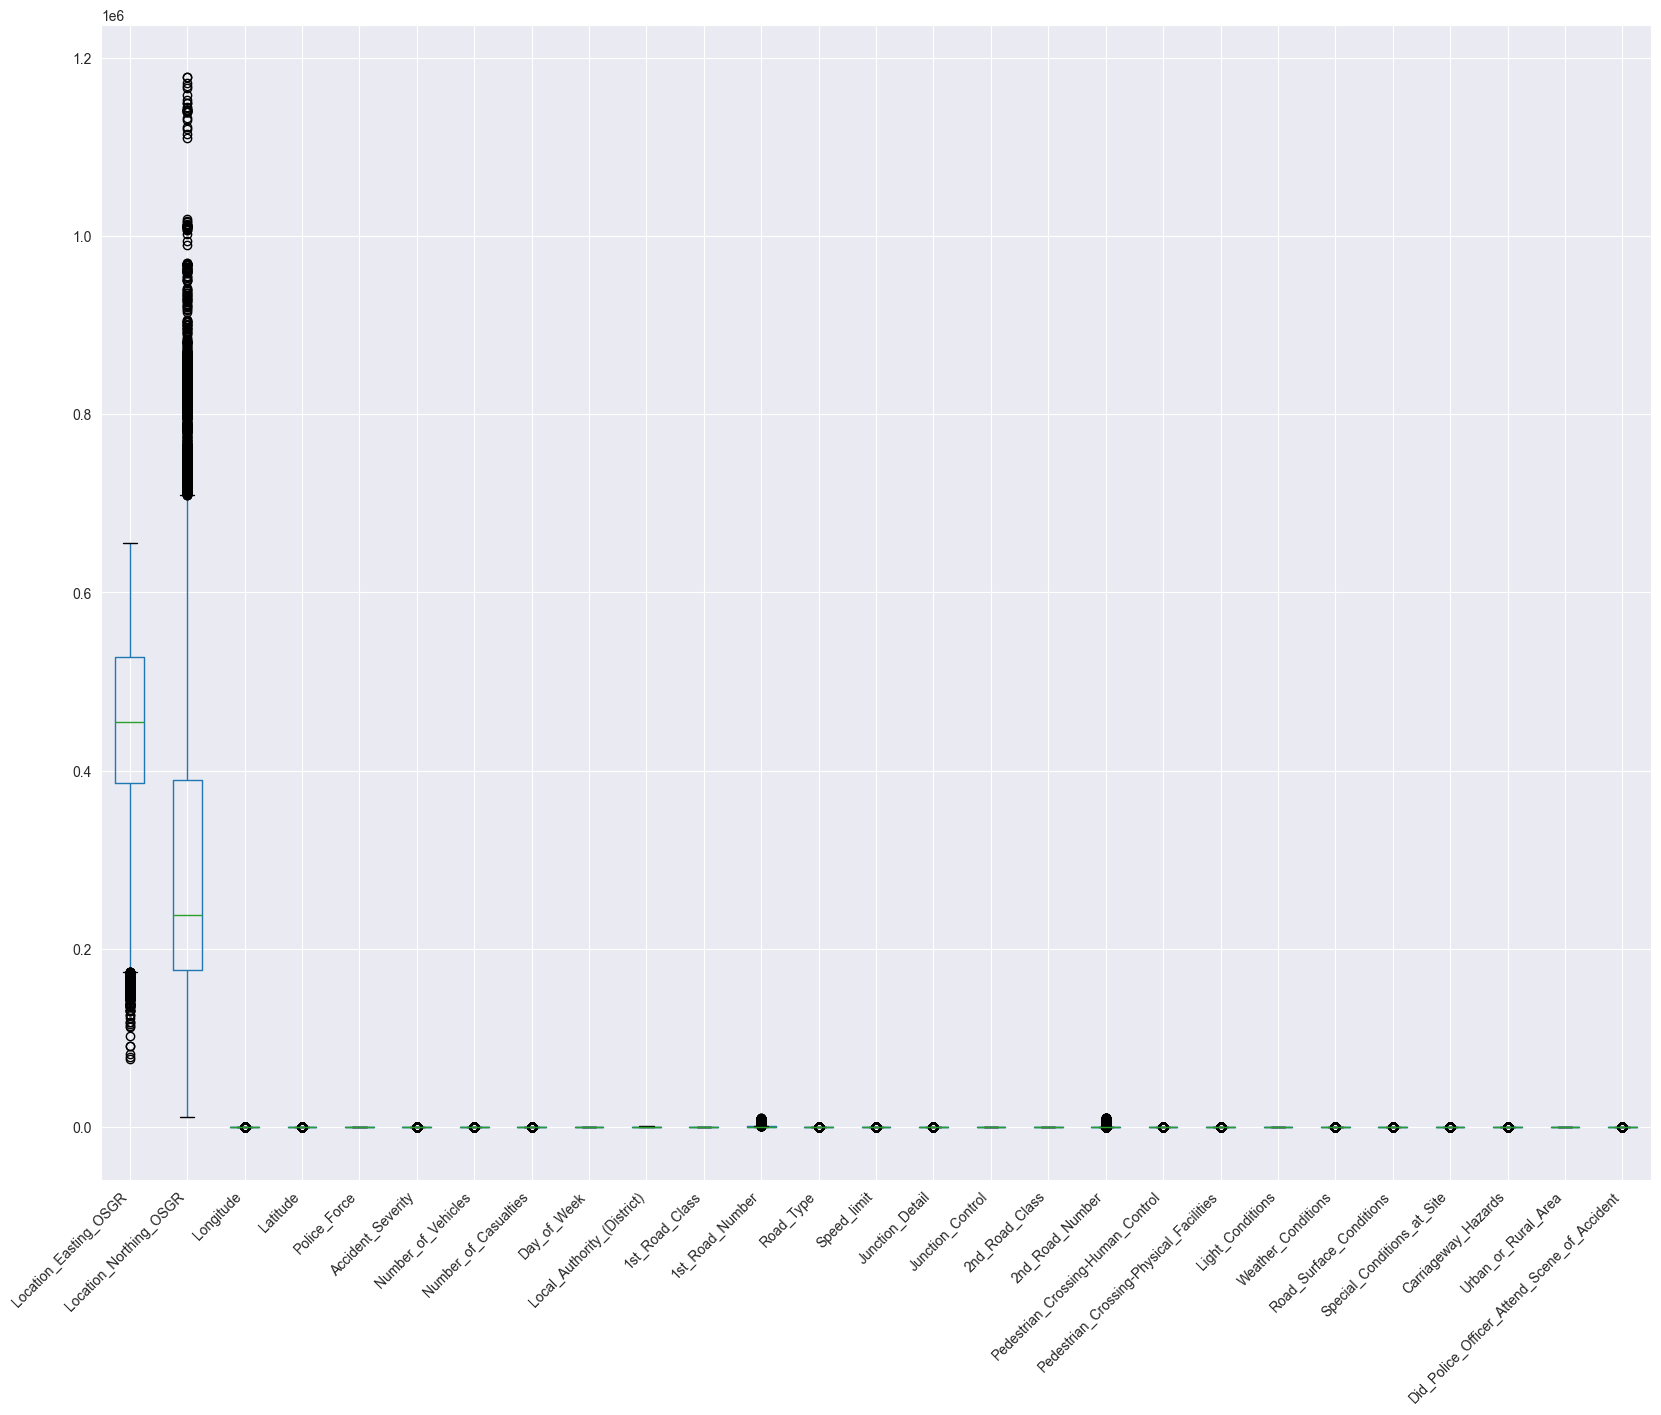

In [97]:
Accidents.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)

### Wykresy dotyczące groźności wypadków

<Axes: xlabel='Accident_Severity', ylabel='Number_of_Casualties'>

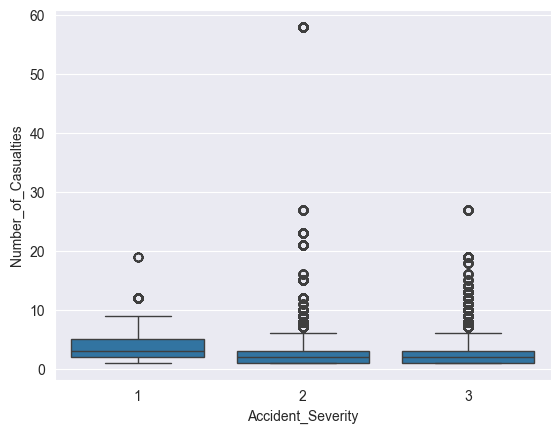

In [98]:
sns.boxplot(x='Accident_Severity', y='Number_of_Casualties', data=Comp_data)

<Axes: xlabel='Accident_Severity', ylabel='count'>

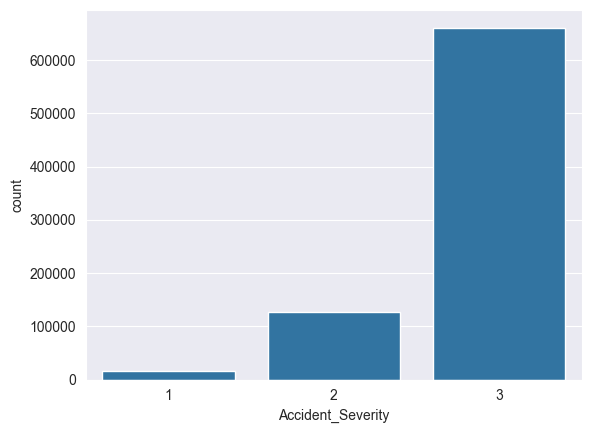

In [99]:
countplt = sns.countplot(x='Accident_Severity', data=Comp_data)
countplt

### Wyodrębnienie kolumny dotyczącej powodu podróży kierowcy

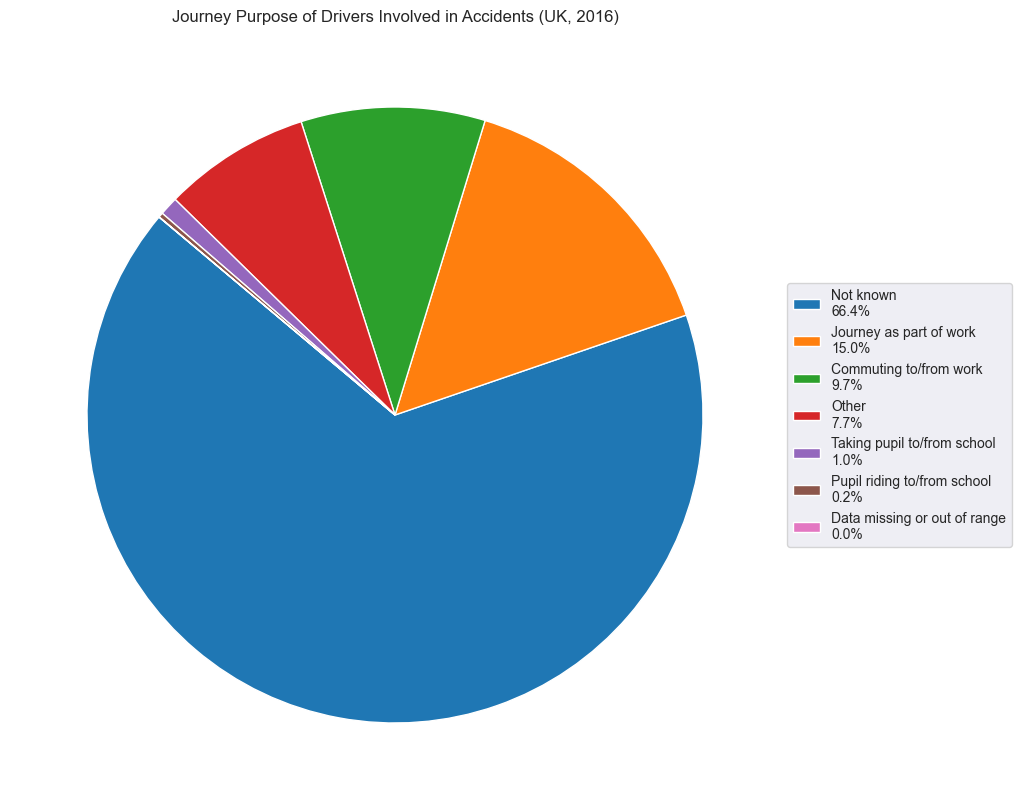

In [100]:
journey_purpose_counts = Data_no_geo['Journey_Purpose_of_Driver_y'].value_counts()

# Tworzenie opisów do legendy
journey_purpose_legend = {
    1: 'Journey as part of work',
    2: 'Commuting to/from work',
    3: 'Taking pupil to/from school',
    4: 'Pupil riding to/from school',
    5: 'Other',
    6: 'Not known',
    -1: 'Data missing or out of range'
}

# Podstawienie opisów do wartości
journey_purpose_counts.index = journey_purpose_counts.index.map(journey_purpose_legend)

plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(journey_purpose_counts, startangle=140, autopct='', labels=None)

# Dodawanie ręcznie etykiet procentowych na zewnątrz koła
percent = journey_purpose_counts / journey_purpose_counts.sum() * 100
labels = [f'{label}\n{percentage:.1f}%' for label, percentage in zip(journey_purpose_counts.index, percent)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Journey Purpose of Drivers Involved in Accidents (UK, 2016)')
plt.show()

### Mapa wypadków drogowych w Wielkiej Brytanii

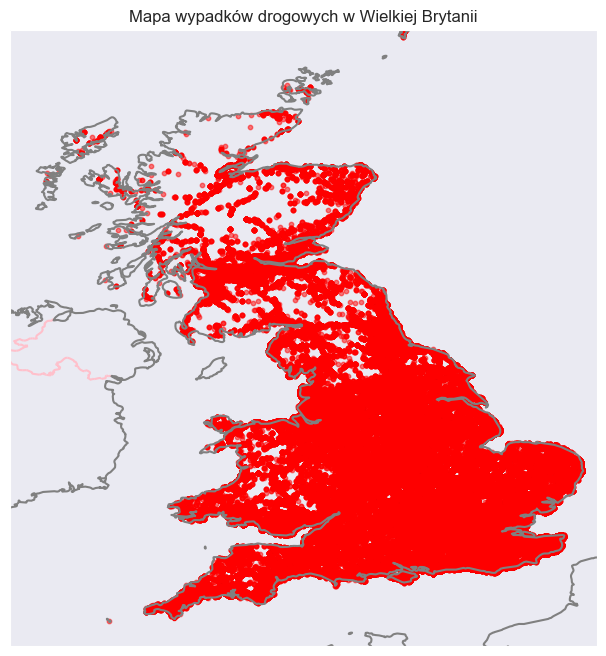

In [101]:
# Utworzenie wykresu mapy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-8, 2, 49.5, 60], crs=ccrs.PlateCarree())  # Ustawienie granic na Wielką Brytanię

# Dodanie warstwy granic kraju na różowo z wbudowanych danych
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=1.5, edgecolor='pink')

# Dodanie warstwy granic Wielkiej Brytanii z wbudowanych danych
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.5, edgecolor='gray')

# Dodanie punktów reprezentujących wypadki drogowe
ax.scatter(Comp_data['Longitude'], Comp_data['Latitude'], transform=ccrs.PlateCarree(), color='red', alpha=0.5, s=10)

plt.title('Mapa wypadków drogowych w Wielkiej Brytanii')
plt.show()

### Wykres wypadków drogowych według marek samochodów

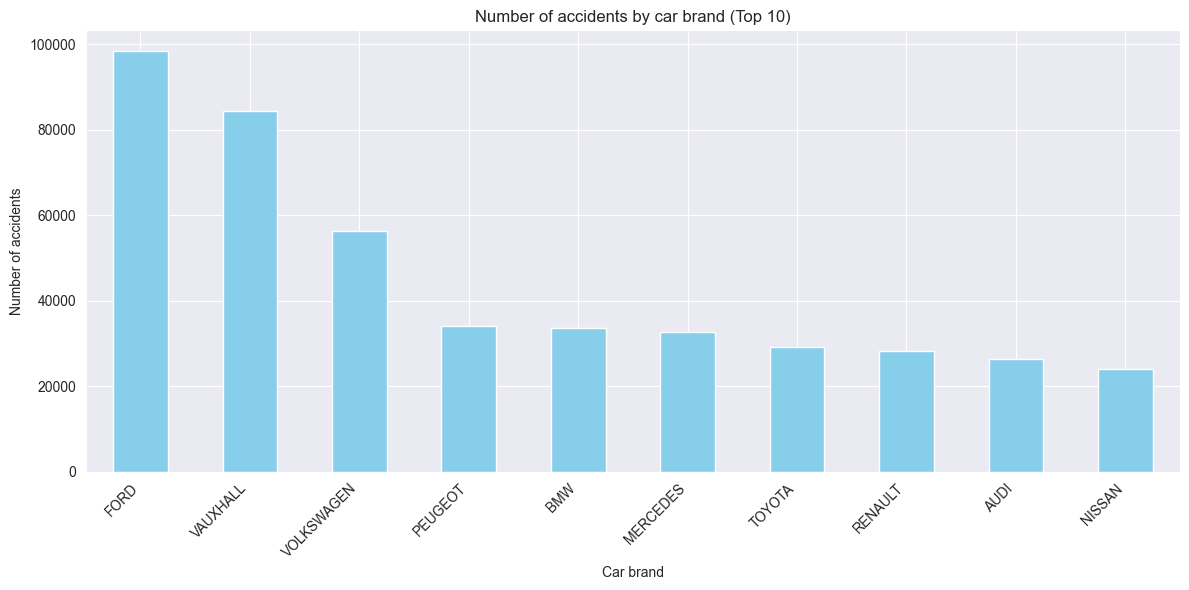

In [102]:
# Analiza liczby wypadków według marki pojazdu
wypadki_marka_auta = Data_no_geo.groupby('make')['Accident_Index'].count().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
wypadki_marka_auta.head(10).plot(kind='bar', color='skyblue')
plt.title('Number of accidents by car brand (Top 10)')
plt.xlabel('Car brand')
plt.ylabel('Number of accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Wykres kołowy wypadków drogowych według płci 

Liczba wypadków według płci:
Sex_of_Driver_y
Data missing       114
Male            520793
Female          231473
Unknown          52473
Name: Accident_Index, dtype: int64


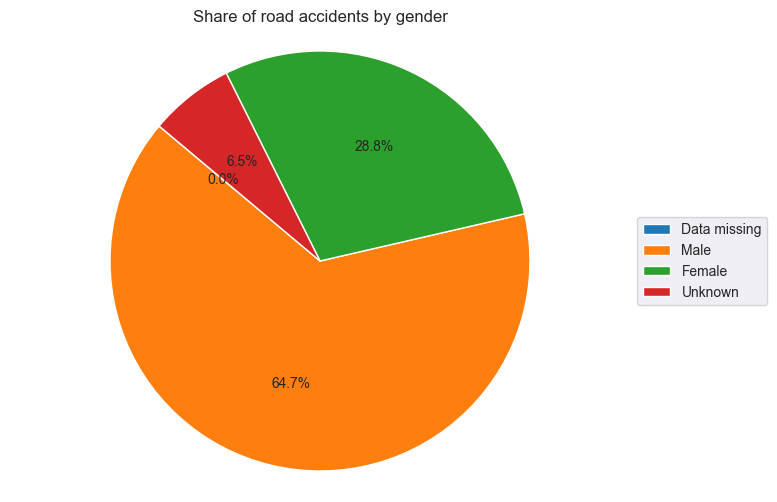

In [103]:
wypadki_plec_legend = {
    1: 'Male',
    2: 'Female',
    3: 'Unknown',
    -1: 'Data missing'
}

# Analiza wypadków według płci
wypadki_wedlug_plci = Data_no_geo.groupby('Sex_of_Driver_y')['Accident_Index'].count()

wypadki_wedlug_plci.index = wypadki_wedlug_plci.index.map(wypadki_plec_legend)

print("Liczba wypadków według płci:")
print(wypadki_wedlug_plci)

plt.figure(figsize=(8, 6))
plt.pie(wypadki_wedlug_plci, autopct='%1.1f%%', startangle=140)
plt.title('Share of road accidents by gender')
plt.axis('equal') 
plt.legend(labels=wypadki_wedlug_plci.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Wykres słupkowy wypadków drogowych według wieku kierowców

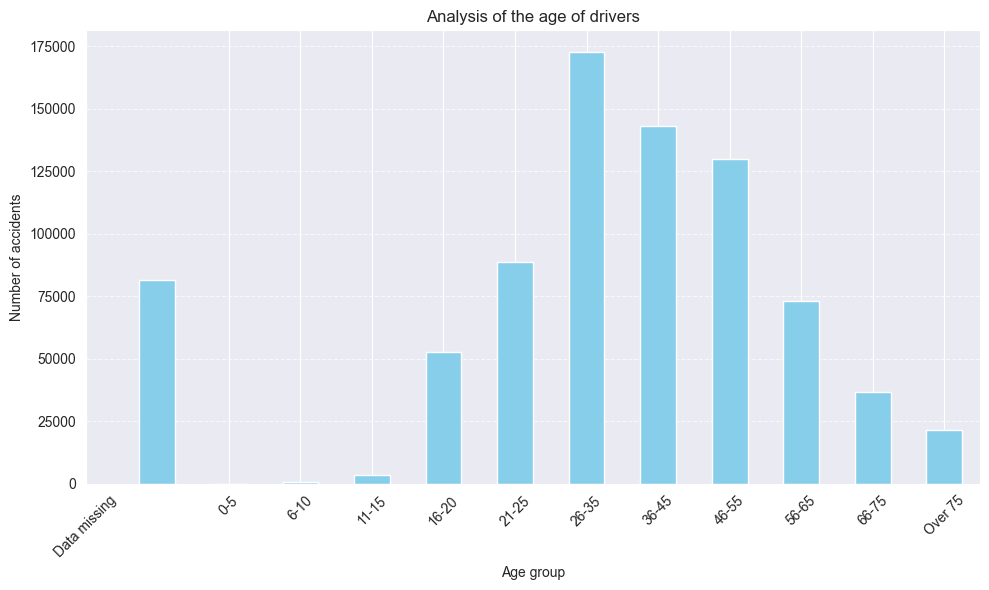

In [104]:
# Analiza wieku kierowców
analiza_wieku = Data_no_geo['Age_Band_of_Driver_y'].value_counts().sort_index()

etykiety = {
    '1': '0-5',
    '2': '6-10',
    '3': '11-15',
    '4': '16-20',
    '5': '21-25',
    '6': '26-35',
    '7': '36-45',
    '8': '46-55',
    '9': '56-65',
    '10': '66-75',
    '11': 'Over 75',
    '-1': 'Data missing'
}


# Tworzenie wykresu słupkowego z etykietami
plt.figure(figsize=(10, 6))
analiza_wieku.plot(kind='bar', color='skyblue')
plt.title('Analysis of the age of drivers')
plt.xlabel('Age group')
plt.ylabel('Number of accidents')
plt.xticks(rotation=45)
plt.xticks(analiza_wieku.index, [etykiety.get(str(x), 'Unknown') for x in analiza_wieku.index])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Pairplot z wybranymi danymi

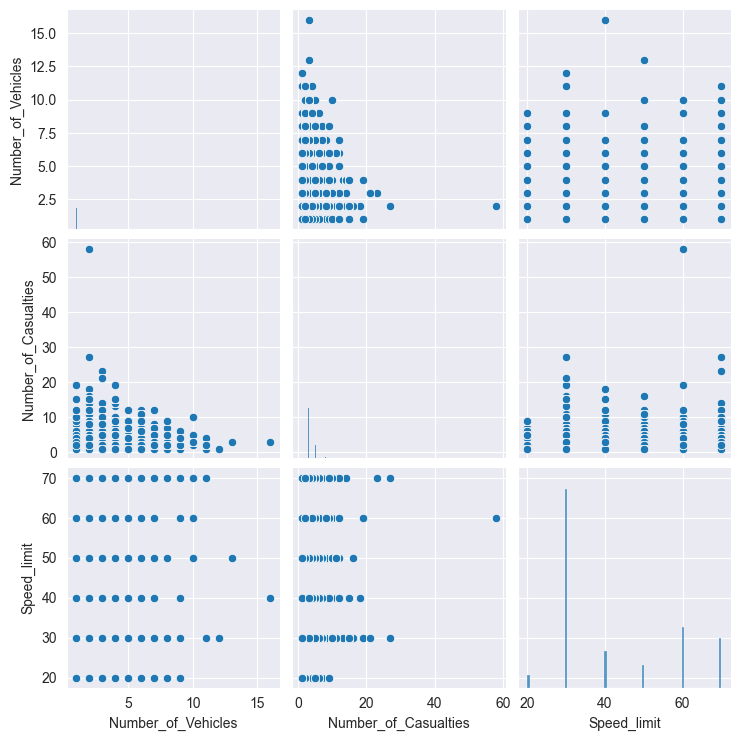

In [105]:
data_to_plot = Comp_data[['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']]

# Przeprowadzenie analizy pairplotów
sns.pairplot(data_to_plot)
plt.show()

### Skalowanie

#### MinMaxScaler

In [106]:
features_to_scale = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(Comp_data[features_to_scale])

Comp_data_scaled = Comp_data.copy()
Comp_data_scaled[features_to_scale] = scaled_features

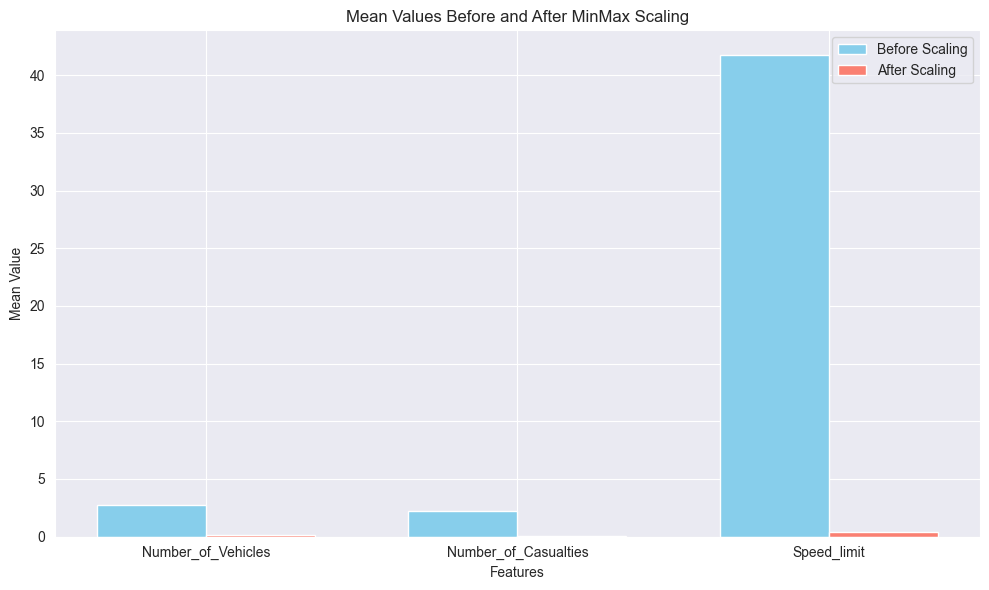

In [107]:
n_features = len(features_to_scale)

data_before_after_scal = np.zeros((2, n_features))

for i, feature in enumerate(features_to_scale):
    data_before_after_scal[0, i] = Comp_data[feature].mean()
    data_before_after_scal[1, i] = Comp_data_scaled[feature].mean()

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(n_features)

plt.bar(index, data_before_after_scal[0], bar_width, label='Before Scaling', color='skyblue')
plt.bar(index + bar_width, data_before_after_scal[1], bar_width, label='After Scaling', color='salmon')

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean Values Before and After MinMax Scaling')
plt.xticks(index + bar_width / 2, features_to_scale)
plt.legend()

plt.tight_layout()
plt.show()

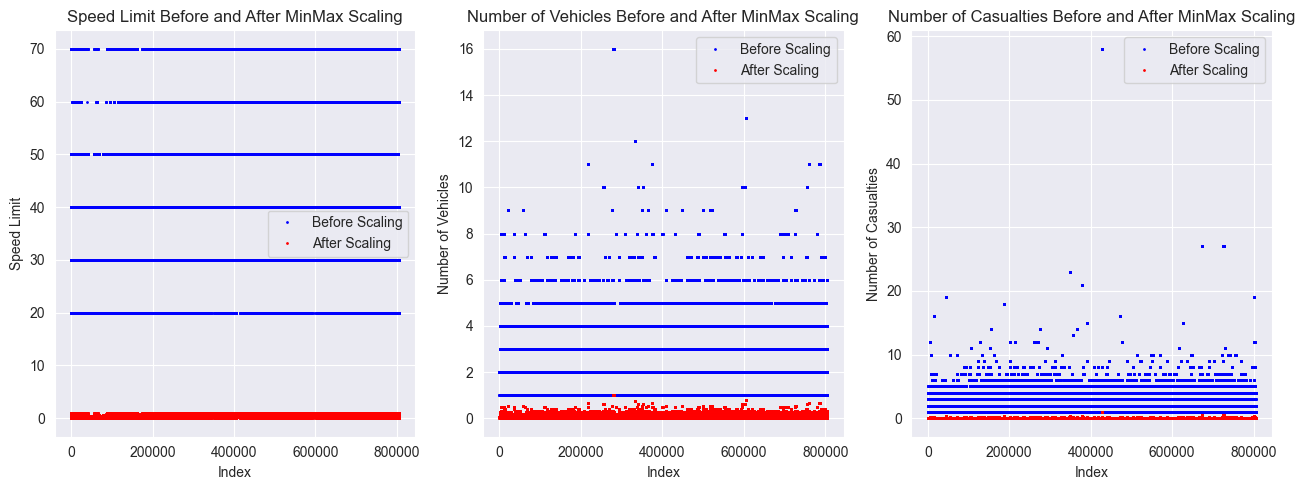

In [108]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
plt.plot(Comp_data['Speed_limit'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled['Speed_limit'], 'ro', markersize=1, label='After Scaling')
plt.title('Speed Limit Before and After MinMax Scaling')
plt.xlabel('Index')
plt.ylabel('Speed Limit')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(Comp_data['Number_of_Vehicles'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled['Number_of_Vehicles'], 'ro', markersize=1, label='After Scaling')
plt.title('Number of Vehicles Before and After MinMax Scaling')
plt.xlabel('Index')
plt.ylabel('Number of Vehicles')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(Comp_data['Number_of_Casualties'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled['Number_of_Casualties'], 'ro', markersize=1, label='After Scaling')
plt.title('Number of Casualties Before and After MinMax Scaling')
plt.xlabel('Index')
plt.ylabel('Number of Casualties')
plt.legend()

plt.tight_layout()
plt.show()

#### StandardScaler

In [109]:
features_to_scale = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']

scaler_st = StandardScaler()
scaled_features_st = scaler_st.fit_transform(Comp_data[features_to_scale])

Comp_data_scaled_st = Comp_data.copy()
Comp_data_scaled_st[features_to_scale] = scaled_features_st

In [110]:
scaled_features_st

array([[-0.50383842, -0.59274785, -0.74636176],
       [-0.50383842, -0.59274785, -0.74636176],
       [-0.50383842, -0.59274785, -0.74636176],
       ...,
       [-1.20071962,  0.39698889, -0.11341436],
       [-1.20071962, -0.09787948,  1.78542784],
       [-1.20071962, -0.09787948,  1.78542784]])

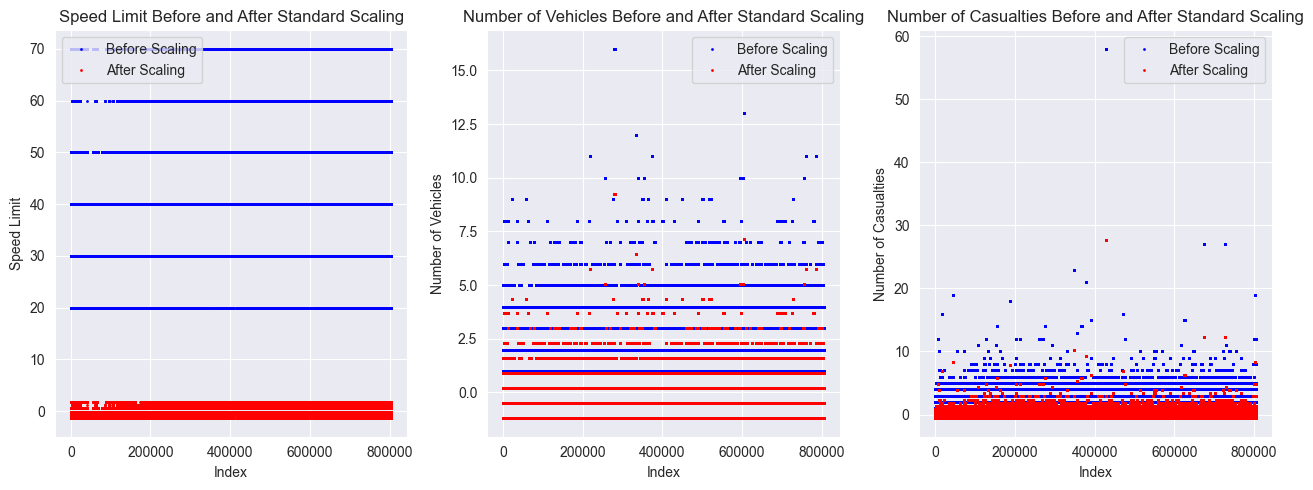

In [111]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
plt.plot(Comp_data['Speed_limit'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled_st['Speed_limit'], 'ro', markersize=1, label='After Scaling')
plt.title('Speed Limit Before and After Standard Scaling')
plt.xlabel('Index')
plt.ylabel('Speed Limit')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(Comp_data['Number_of_Vehicles'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled_st['Number_of_Vehicles'], 'ro', markersize=1, label='After Scaling')
plt.title('Number of Vehicles Before and After Standard Scaling')
plt.xlabel('Index')
plt.ylabel('Number of Vehicles')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(Comp_data['Number_of_Casualties'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled_st['Number_of_Casualties'], 'ro', markersize=1, label='After Scaling')
plt.title('Number of Casualties Before and After Standard Scaling')
plt.xlabel('Index')
plt.ylabel('Number of Casualties')
plt.legend()

plt.tight_layout()
plt.show()
